## Sentinel-1 Offset Tracking for glacier velocity maps

### Objective

Apply the offset tracking technique to derive the glacier velocity maps.

The goal of this tutorial is to provide novice and experienced remote sensing users with a workflow using the Offset Tracking tools in generating glacier velocity maps with Sentinel-1 Level-1 Ground Range Detected (GRD) products.

Offset Tracking is a technique that measures feature motion between two images using patch intensity cross-correlation optimization. It is widely used in glacier motion estimation.

### <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

Data products are available in single polarisation (VV or HH) for Wave mode and dual polarisation (VV+VH or HH+HV) and single polarisation (HH or VV) for SM, IW and EW modes.

Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and projected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has approximately square resolution pixels and square pixel spacing with reduced speckle at the cost of reduced geometric resolution.

GRD products can be in one of three resolutions:

* Full Resolution (FR)
* High Resolution (HR)
* Medium Resolution (MR).

The resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR and HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.

### Workflow

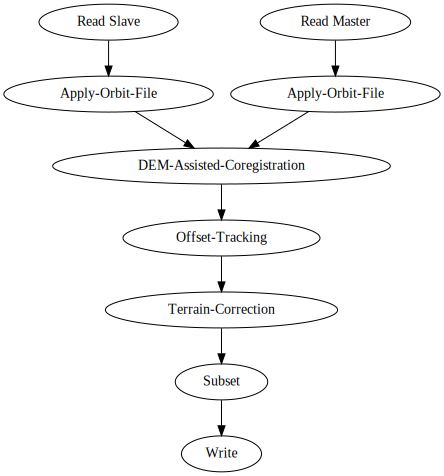

In [1]:
from graphviz import Digraph

dot = Digraph()
dot.node('A', 'Read Slave')
dot.node('B', 'Apply-Orbit-File')
dot.node('C', 'Read Master')
dot.node('D', 'Apply-Orbit-File')
dot.node('E', 'DEM-Assisted-Coregistration')
dot.node('F', 'Offset-Tracking')
dot.node('G', 'Terrain-Correction')
dot.node('H', 'Subset')
dot.node('I', 'Write')

dot.edges(['AB', 'BE', 'CD', 'DE', 'EF', 'FG', 'GH', 'HI'])

dot

In [2]:
glacier_center = dict([('id', 'glacier_center'),
               ('value', '-35.3,83.9'),
               ('title', 'Glacier center (lon, lat)'),
               ('abstract', 'Glacier center (lon, lat)')])

In [3]:
geo_extent = dict([('id', 'geo_extent'),
               ('value', '50000'),
               ('title', 'Extent around the glacier center in meters'),
               ('abstract', 'Extent around the glacier center in meters')])

### The Python modules required

In [4]:
import pandas as pd
from geopandas import GeoDataFrame
import geopandas as gp
from shapely.wkt import loads
import cioppy
import numpy as np
from datetime import datetime
import gdal
%matplotlib inline
import matplotlib.pyplot as plt
import tempfile
import lxml.etree as etree
import subprocess
import tempfile
import time
import psutil
import os


from snappy import jpy
from snappy import ProductIO
from snappy import GPF
from snappy import HashMap
from osgeo import ogr
from osgeo import osr
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.wkt import loads
from shapely import geometry
import numpy as np
import ipyleaflet
from ipyleaflet import *

from ipywidgets import HTML

from datetime import datetime

import cioppy

import lxml.etree as etree

import math
import sys
sys.path.append(os.getcwd())
import ellip_snap_helpers

%load_ext autoreload
%autoreload 2

### Extend the area of interest around the glacier

As done before, we extend the area of interest using the EPSG 3575:

In [5]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [6]:
def extend_aoi(center_x, center_y, extent):
    
    polar_epsg = 3575 # 3995
    latlon_epsg = 4326
    
    center_polar = loads(convert_coords(latlon_epsg, polar_epsg, Point(center_x, center_y).wkt))
    
    ll = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [7]:
glacier_center_x, glacier_center_y = [float(x) for x in glacier_center['value'].split(',')] 

In [8]:
aoi_wkt = extend_aoi(glacier_center_x, glacier_center_y, float(geo_extent['value']))

aoi_wkt

'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'

In [9]:
global m

from ipyleaflet import Map, Polygon

m = Map(center=(glacier_center_y, 
                glacier_center_x), zoom=5)

aoi = Polygon(
    locations=np.asarray([t[::-1] for t in list(loads(aoi_wkt).exterior.coords)]).tolist(),
    color="green",
    fill_color="green"
)

m += aoi
m

TWFwKGJhc2VtYXA9eyd1cmwnOiAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLCAnbWF4X3pvb20nOiAxOSwgJ2F0dHJpYnV0aW9uJzogJ01hcCDigKY=


### Discovery of the master Sentinel-1 product

In order to generate glacier velocity map using the Offset Tracking tool, the input products must
be two GRD products, one slave and one master, over the same area acquired at different times. 

The time interval should be as short as possible. 

Read the saved containing the selected Sentinel-1 acquisition during the Polarstern AIS data analysis

In [10]:
slave_prd = GeoDataFrame(pd.read_pickle('s1_prd.pickle'))



In [11]:
slave_prd['startdate'] = pd.to_datetime(slave_prd['startdate'])  

Set the time of interest to a Sentinel-1 cycle (twelve days): 

In [12]:
start_time = (slave_prd.iloc[0]['startdate'] - np.timedelta64(12, 'D')).isoformat() + 'Z'

stop_time = (slave_prd.iloc[0]['startdate'] - np.timedelta64(1, 'D')).isoformat() + 'Z'
                        


Set the area of interest as the slave footprint:

In [13]:
wkt = slave_prd.iloc[0]['wkt'].wkt

The offset tracking approach requires products of the same track:

In [14]:
track = slave_prd.iloc[0]['track']

Build the search parameters:

In [15]:
search_params = dict([('geom', wkt),
                      ('start', start_time),
                      ('stop', stop_time),
                      ('track', track),
                      ('do','terradue'),
                      ('pt', 'GRD')])

print search_params 

{'do': 'terradue', 'pt': 'GRD', 'track': '99', 'stop': '2018-08-21T11:41:38.660000Z', 'start': '2018-08-10T11:41:38.660000Z', 'geom': 'POLYGON ((-37.121357 81.783356, -61.739033 84.10655199999999, -31.865376 86.972076, -11.720141 83.541039, -37.121357 81.783356))'}


Do the search to retrieve the candidate masters:

In [16]:
series = 'https://catalog.terradue.com/sentinel1/search'

ciop = cioppy.Cioppy()

masters = GeoDataFrame(ciop.search(end_point=series, 
                     params=search_params,
                     output_fields='identifier,enclosure,self,startdate,track,wkt',
                     model='EOP'))
                            

Update the _wkt_ column to a geometry and the _startdate_ to date/time:

In [17]:
masters['wkt'] = masters['wkt'].apply(loads)
masters['startdate'] = pd.to_datetime(masters['startdate'])  

In [18]:
masters.head()

,enclosure,identifier,self,startdate,track,wkt
0,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDH_1SDH_20180810T114237_20180810T1143...,https://catalog.terradue.com/sentinel1/search?...,2018-08-10 11:42:37.754744,99,"POLYGON ((-52.067234 79.08316000000001, -71.51..."
1,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180810T114237_20180810T1143...,https://catalog.terradue.com/sentinel1/search?...,2018-08-10 11:42:37.755495,99,"POLYGON ((-52.065311 79.083237, -71.515289 80...."
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180810T114137_20180810T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-10 11:41:37.756673,99,"POLYGON ((-37.125397 81.78415699999999, -61.74..."


Define a function to determine:

* the overlap between acquisition footprints - **slave_coverage**
* the intersection with the AOI - **aoi_intersection**
* the temporal baseline in days between the master and the slave - **temporal_baseline**

In [19]:
def analyse(row, slave, aoi_wkt):

    aoi = loads(aoi_wkt)
    
    slave_wkt =  slave.iloc[0]['wkt']
    slave_date = slave.iloc[0]['startdate']
    
    slave_coverage = row['wkt'].area / slave_wkt.area * 100
    aoi_intersection = (row['wkt'].intersection(aoi).area / aoi.area) * 100
    temporal_baseline = round(divmod((slave_date - row['startdate']).total_seconds(), 3600 * 24)[0] +
                              round(divmod((slave_date - row['startdate']).total_seconds(), 3600 * 24)[1])/(3600 * 24))
    
    series = dict([('slave_coverage', slave_coverage),
                  ('aoi_intersection', aoi_intersection),
                  ('temporal_baseline', temporal_baseline)])
    
    return pd.Series(series)
    

Add the columns to the masters 

In [20]:
masters = masters.merge(masters.apply(lambda row: analyse(row, slave_prd, aoi_wkt), axis=1), 
              left_index=True,
              right_index=True)

Select the _best_ master: biggest AOI intersection and lowest temporal baseline:

In [21]:
masters.sort_values(['aoi_intersection', 'temporal_baseline'], ascending=[False, True]).iloc[0]

enclosure            https://store.terradue.com/download/sentinel1/...
identifier           S1B_EW_GRDM_1SDH_20180810T114137_20180810T1142...
self                 https://catalog.terradue.com/sentinel1/search?...
startdate                                   2018-08-10 11:41:37.756673
track                                                               99
wkt                  POLYGON ((-37.125397 81.78415699999999, -61.74...
aoi_intersection                                                   100
slave_coverage                                                 100.012
temporal_baseline                                                   12
Name: 2, dtype: object

In [22]:
masters.sort_values(['aoi_intersection', 'temporal_baseline'], ascending=[False, True]).iloc[0].name

2

In [23]:
masters.iloc[[masters.sort_values(['aoi_intersection', 'temporal_baseline'], ascending=[False, True]).iloc[0].name]]

,enclosure,identifier,self,startdate,track,wkt,aoi_intersection,slave_coverage,temporal_baseline
2,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180810T114137_20180810T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-10 11:41:37.756673,99,"POLYGON ((-37.125397 81.78415699999999, -61.74...",100.0,100.012058,12.0


In [24]:
master_prd = masters.iloc[[masters.sort_values(['aoi_intersection', 'temporal_baseline'], ascending=[False, True]).iloc[0].name]]

In [25]:
slave_prd

,enclosure,identifier,self,startdate,track,wkt,contains,local_path
4,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660,99,"POLYGON ((-37.121357 81.783356, -61.739033 84....",True,/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114...


Create a data frame with the pair:

In [26]:
pair = pd.concat([master_prd.drop(['aoi_intersection', 'slave_coverage', 'temporal_baseline'], axis=1),  
                  slave_prd])

In [27]:
pair

,contains,enclosure,identifier,local_path,self,startdate,track,wkt
2,NaN,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180810T114137_20180810T1142...,NaN,https://catalog.terradue.com/sentinel1/search?...,2018-08-10 11:41:37.756673,99,"POLYGON ((-37.125397 81.78415699999999, -61.74..."
4,True,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660000,99,"POLYGON ((-37.121357 81.783356, -61.739033 84...."


Add the Sentinel-1 pair discovered:

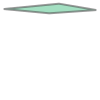

In [28]:
pair.iloc[0]['wkt']

In [29]:
slave_map = Polygon(
    locations=np.asarray([t[::-1] for t in list(pair.iloc[1]['wkt'].exterior.coords)]).tolist(),
    color='red',
    fill_color='red',
    weight=6,
    fill_opacity=0.1
)

master_map = Polygon(
    locations=np.asarray([t[::-1] for t in list(pair.iloc[0]['wkt'].exterior.coords)]).tolist(),
    color='yellow',
    fill_color='yellow',
    weight=3,
    fill_opacity=0.1
)

m += slave_map
m += master_map


Stage-in the master product

In [30]:
pair.iloc[0]['local_path']

nan

In [31]:
type(pair.iloc[0]['local_path'])

float

Stage-in the product:

In [32]:
target_dir = '/workspace/data2'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

def stage_in(row):
    
    if isinstance(row['local_path'], float):
        
        if math.isnan(row['local_path']):

            print row['enclosure']
            local_path = ciop.copy(row['enclosure'], extract=False, target=target_dir)
            row['local_path'] = local_path
        
    return row 
    

In [33]:
pair = pair.apply(lambda row: stage_in(row), axis=1)

https://store.terradue.com/download/sentinel1/files/v1/S1B_EW_GRDM_1SDH_20180810T114137_20180810T114237_012200_016799_1944


Now the Sentinel-1 data frame has the local_path information for both products and looks like:

In [34]:
pair

,contains,enclosure,identifier,local_path,self,startdate,track,wkt
2,NaN,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180810T114137_20180810T1142...,/workspace/data2/S1B_EW_GRDM_1SDH_20180810T114...,https://catalog.terradue.com/sentinel1/search?...,2018-08-10 11:41:37.756673,99,"POLYGON ((-37.125397 81.78415699999999, -61.74..."
4,True,https://store.terradue.com/download/sentinel1/...,S1B_EW_GRDM_1SDH_20180822T114138_20180822T1142...,/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114...,https://catalog.terradue.com/sentinel1/search?...,2018-08-22 11:41:38.660000,99,"POLYGON ((-37.121357 81.783356, -61.739033 84...."


The local files to process are thus:

In [35]:
pair[['enclosure']]

,enclosure
2,https://store.terradue.com/download/sentinel1/...
4,https://store.terradue.com/download/sentinel1/...


In [36]:
local_paths = list(pair['local_path'].values)

local_paths

['/workspace/data2/S1B_EW_GRDM_1SDH_20180810T114137_20180810T114237_012200_016799_1944.zip',
 '/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip']

### Offset tracking workflow

Create a SNAP graph

In [37]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.getcwd())
import ellip_snap_helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
mygraph = ellip_snap_helpers.GraphProcessor()

#### Read the products

In [39]:
operator = 'Read'

read_nodes = []

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

for index, s1path in enumerate(local_paths):
   
    parameters['file'] = s1path
   
    node_id = 'Read(%s)' % index
    
    read_nodes.append(node_id)
    
    mygraph.add_node(node_id, 'Read', parameters, '')


The graph now contains two nodes for reading the pair of Sentinel-1 products:

In [40]:
mygraph.view_graph()

<graph>
  <version>1.0</version>
  <node id="Read(0)">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/workspace/data2/S1B_EW_GRDM_1SDH_20180810T114137_20180810T114237_012200_016799_1944.zip</file>
    </parameters>
  </node>
  <node id="Read(1)">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip</file>
    </parameters>
  </node>
</graph>



### Apply orbit file SNAP Operator

The orbit state vectors provided in the metadata of a SAR product are generally not accurate and can be refined with the precise orbit files which are available days-to-weeks after the generation of the product. 

The orbit file provides accurate satellite position and velocity information. Based on this information, the orbit state vectors in the abstract metadata of the product are updated.

The Precise Orbit Determination (POD) service for SENTINEL-1 provides Restituted orbit files and Precise Orbit Ephemerides (POE) orbit files. POE files cover approximately 28 hours and contain orbit state vectors at fixed time steps of 10 seconds intervals. Files are generated one file per day and are delivered within 20 days after data acquisition. 

Get the parameters of the **Apply orbit file** SNAP Operator:

In [41]:
operator = 'Apply-Orbit-File'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

Apply the operator:

In [42]:
orbit_nodes = []

for index, source_node in enumerate(read_nodes):
    
    node_id = 'Apply-Orbit-File(%s)' % index
    
    orbit_nodes.append(node_id)
    
    mygraph.add_node(node_id, 'Apply-Orbit-File', parameters, source_node)
    
    

In [43]:
mygraph.view_graph()

<graph>
  <version>1.0</version>
  <node id="Read(0)">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/workspace/data2/S1B_EW_GRDM_1SDH_20180810T114137_20180810T114237_012200_016799_1944.zip</file>
    </parameters>
  </node>
  <node id="Read(1)">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip</file>
    </parameters>
  </node>
  <node id="Apply-Orbit-File(0)">
    <operator>Apply-Orbit-File</operator>
    <sources>
      <sourceProduct refid="Read(0)"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <polyDegree>3</polyDegree>
      <orbitType>Sentinel Precise (Auto Download)</orbitType>
      <continueOnFail>false</continueOnFail>
    </parameters>
  </node>
  <node id="Apply

## DEM Assisted Coregistration

For Offset Tracking processing, two images must be coregistered into a stack. 

The image that was acquired earlier is selected as the master and the other image is selected as the slave. The pixels in slave image will be moved to align with the master image with the help of the orbital data and a reference DEM.

Coregistration ensures that each ground target from stationary scene contributes to the same (range, azimuth) pixel in both the master and the slave image.

For Offset Tracking application, DEM Assisted Coregistration is used. It coregisters the products strictly based on the geometry using a DEM, orbit positions and times. This avoids possibly warping the image incorrectly due to the movement in the scene.


The default DEM, which is SRTM 3 Sec, covers most area of the earth's surface between –60 degree latitude and +60 degree latitude. However, it does not cover the high latitude area where Rink Glacier is located. 

Therefore, ASTER GDEM, GETASSE30 or ACE30 DEM could be selected. 

In [44]:
operator = 'DEM-Assisted-Coregistration'

node_id = 'DEM-Assisted-Coregistration'

source_nodes = ['Apply-Orbit-File(0)', 'Apply-Orbit-File(1)']

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['demName'] = 'ACE30'

parameters

{'demName': 'ACE30',
 'demResamplingMethod': 'BICUBIC_INTERPOLATION',
 'externalDEMFile': None,
 'externalDEMNoDataValue': '0',
 'maskOutAreaWithoutElevation': 'true',
 'outputRangeAzimuthOffset': 'false',
 'resamplingType': 'BISINC_5_POINT_INTERPOLATION',
 'tileExtensionPercent': '50'}

In [45]:
mygraph.add_node(node_id, operator, parameters, source_nodes)

In [46]:
mygraph.view_graph()

<graph>
  <version>1.0</version>
  <node id="Read(0)">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/workspace/data2/S1B_EW_GRDM_1SDH_20180810T114137_20180810T114237_012200_016799_1944.zip</file>
    </parameters>
  </node>
  <node id="Read(1)">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/workspace/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip</file>
    </parameters>
  </node>
  <node id="Apply-Orbit-File(0)">
    <operator>Apply-Orbit-File</operator>
    <sources>
      <sourceProduct refid="Read(0)"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <polyDegree>3</polyDegree>
      <orbitType>Sentinel Precise (Auto Download)</orbitType>
      <continueOnFail>false</continueOnFail>
    </parameters>
  </node>
  <node id="Apply

### Offset-Tracking

The Offset Tracking operator estimates the movement of glacier surfaces between master and slave images in both slant-range and azimuth direction. It performs cross-correlation on selected Ground Control Point (GCP) in master and slave images. 

Then the glacier velocities on the selected GCPs are computed based on the offsets estimated by the cross-correlation. Finally the glacier velocity map is generated through interpolation of the velocities computed on the GCP grid.

The Offset Tracking is performed in the following sub-steps:

* For each point in the user specified GCP grid in master image, compute its corresponding pixel position in slave image using normalized cross-correlation.
* If the compute offset between master and slave GCP positions exceeds the maximum offset (computed from user specified maximum velocity), then the GCP point is marked as outlier.
*  Perform local average for the offset on valid GCP points.
*  Fill holes caused by the outliers. The offset at hole point will be replaced by a new offset computed by local weighted average.
*  Compute the velocities for all points on GCP grid from their offsets.
*  Finally, compute velocities for all pixels in the master image from the velocities on GCP grid by interpolation.

In [47]:
operator = 'Offset-Tracking'

node_id = 'Offset-Tracking'

source_node = 'DEM-Assisted-Coregistration'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['maxVelocity'] = '5'

parameters

{'averageBoxSize': '5',
 'fillHoles': 'true',
 'gridAzimuthSpacing': '40',
 'gridRangeSpacing': '40',
 'maxVelocity': '5',
 'radius': '4',
 'registrationWindowHeight': '128',
 'registrationWindowWidth': '128',
 'resamplingType': 'BICUBIC_INTERPOLATION',
 'roiVector': None,
 'spatialAverage': 'true',
 'xCorrThreshold': '0.1'}

In [48]:
mygraph.add_node(node_id, operator, parameters, source_node)

### Terrain correction

In [49]:
map_proj = """PROJCS["WGS 84 / Arctic Polar Stereographic", 
  GEOGCS["WGS 84", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic longitude", EAST], 
    AXIS["Geodetic latitude", NORTH], 
    AUTHORITY["EPSG","4326"]], 
  PROJECTION["Polar Stereographic (variant B)", AUTHORITY["EPSG","9829"]], 
  PARAMETER["central_meridian", 0.0], 
  PARAMETER["Standard_Parallel_1", 71.0], 
  PARAMETER["false_easting", 0.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", "South along 90 deg East"], 
  AXIS["Northing", "South along 180 deg"], 
  AUTHORITY["EPSG","3995"]]"""

In [50]:
operator = 'Terrain-Correction'

node_id = 'Terrain-Correction'

source_node = 'Offset-Tracking'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['demName'] = 'ACE30'
parameters['mapProjection'] = map_proj    
parameters['nodataValueAtSea'] = 'false'   

In [51]:
mygraph.add_node(node_id, operator, parameters, source_node)

### Subset

In [52]:
operator = 'Subset'

node_id = 'Subset' 

source_node = 'Terrain-Correction'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['geoRegion'] = aoi_wkt
        
parameters

{'bandNames': None,
 'copyMetadata': 'false',
 'fullSwath': 'false',
 'geoRegion': 'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))',
 'region': None,
 'subSamplingX': '1',
 'subSamplingY': '1',
 'tiePointGridNames': None}

In [53]:
mygraph.add_node(node_id, operator, parameters, source_node)

#### Write node

In [54]:
output_name = 'velocity'

In [55]:
operator = 'Write'

node_id = 'Write' 

source_node = 'Subset' 

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['file'] = output_name
parameters['formatName'] = 'GeoTIFF-BigTiff'


In [56]:
mygraph.add_node(operator, 
             node_id, 
             parameters,
             source_node) 

In [57]:
mygraph.run()

Processing the graph
Process PID: 757
Executing processing graph
Master: 10Aug2018
Slave: 10Aug2018 prep baseline: 0.0 temp baseline: 0.0
Slave: 22Aug2018 prep baseline: -136.77487 temp baseline: -12.0000105

Master: 22Aug2018
Slave: 10Aug2018 prep baseline: 136.7817 temp baseline: 12.0000105
Slave: 22Aug2018 prep baseline: 0.0 temp baseline: 0.0

....10%....20%....30%....40%....50%....60%....70%....80%....90% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.hsqldb.persist.Logger: dataFileCache open start
INFO: org.esa.snap.engine_utilities.download.downloadablecontent.DownloadableContentImpl: http retrieving http://step.esa.int/auxdata/orbits/Sentinel-1/POEORB/S1B/2018/08/S1B_OPER_AUX_POEORB_OPOD_20180830T110609_V20180809T225942_20180811T005942.EOF.zip
INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/ACE30/75N015W.zip
INFO: org.esa.snap.core.dataop.dem.ElevationFile: ht

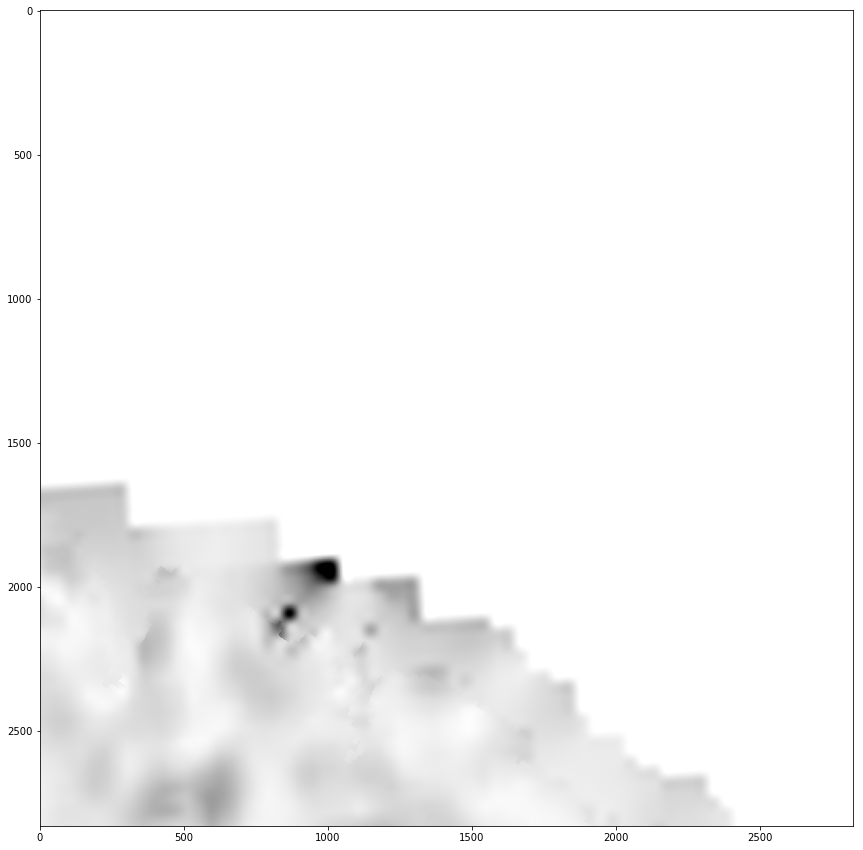

In [58]:
ds = gdal.Open(output_name + '.tif')
band = ds.GetRasterBand(1)

fig = plt.figure(figsize=(15,15))

imgplot = plt.imshow(band.ReadAsArray().astype(np.float),
                         cmap=plt.cm.binary, 
                         vmin=0, 
                         vmax=2.5)

plt.show()

### License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.